In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import torch
from tqdm import tqdm

# Load your dataset
df = pd.read_csv("en_hf_112024.csv")  # Update this path if needed
df = df.iloc[:10000]
# Load model & tokenizer
model_name = "Hate-speech-CNERG/dehatebert-mono-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare pipeline
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

Device set to use cpu


In [85]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")
print(config.id2label)
# preds = []
# for text in tqdm(df["text"].astype(str).tolist()):
#     pred = pipeline(text, truncation=True, max_length=512)[0]
#     label = 1 if pred["label"] == "HATE" else 0  # ✅ CORRECT now
#     preds.append(label)



{0: 'NON_HATE', 1: 'HATE'}


In [78]:
true_labels = df["labels"].tolist()
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds, zero_division=0)
recall = recall_score(true_labels, preds, zero_division=0)
f1 = f1_score(true_labels, preds, zero_division=0)


# Print results
print("\n=== Evaluation Results ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



=== Evaluation Results ===
Accuracy:  0.2157
Precision: 0.2264
Recall:    0.6021
F1 Score:  0.3290


In [20]:
true_labels = df["Label"].tolist()
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds, zero_division=0)
recall = recall_score(true_labels, preds, zero_division=0)
f1 = f1_score(true_labels, preds, zero_division=0)


# Print results
print("\n=== Evaluation Results ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

KeyError: 'Label'

In [5]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained("cardiffnlp/twitter-roberta-base-hate")
print(config.id2label)

{0: 'non-hate', 1: 'hate'}


In [96]:

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate

# -------------------------
# 1. Define Preprocessing Function
# -------------------------
def basic_preprocessing(text):
    """
    Preprocess the text by lowercasing, removing URLs and usernames,
    and stripping extra whitespace.
    """
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)              # Remove usernames
    text = re.sub(r"[^\w\s]", "", text)           # Remove punctuation (optional)
    return text.strip()

def convert_labels(batch):
    # Convert each label to float explicitly.
    batch["Label"] = [float(label) for label in batch["Label"]]
    return batch


# -------------------------
# 2. Load Your Dataset
# -------------------------
# Update the path to your CSV file (the hate superset CSV)
csv_file = "HateSpeechDatasetBalanced.csv"
df = pd.read_csv(csv_file)

# Apply preprocessing to the text column
df["Content"] = df["Content"].astype(str).apply(basic_preprocessing)

# Optional: Check label distribution
print("Label distribution:\n", df["Label"].value_counts())

# -------------------------
# 3. Split the Dataset into Train and Test
# -------------------------
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Label"])

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict with train and test splits
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# -------------------------
# 4. Load the HateBERT Tokenizer and Tokenize the Dataset
# -------------------------
# Set your HateBERT model name (change if needed)
model_name = "Hate-speech-CNERG/dehatebert-mono-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define a tokenization function
def tokenize_function(example):
    return tokenizer(example["Content"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets in batch
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# -------------------------
# 5. Prepare for PyTorch
# -------------------------
# Ensure the label column is called "labels" (if not, rename it)
# Note: The CSV should already have a "labels" column.
# Convert to int if needed
tokenized_datasets = tokenized_datasets.map(convert_labels, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")
# tokenized_datasets = tokenized_datasets.map(lambda x: {"Label": np.float32(x["Label"])})
# tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")
# tokenized_datasets = tokenized_datasets.remove_columns(["post_id", "post_tokens", "annotators", "rationales"]) if "post_id" in tokenized_datasets["train"].column_names else tokenized_datasets
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


# -------------------------
# 6. Load the HateBERT Model for Sequence Classification
# -------------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, ignore_mismatched_sizes=True)

# -------------------------
# 7. Define Training Arguments and Metrics
# -------------------------
training_args = TrainingArguments(
    output_dir="./hatebert_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs > 0.5).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": accuracy, "f1": f1}
tokenized_datasets = tokenized_datasets.map(lambda x: {"labels": x["labels"].float()})

sample = tokenized_datasets["train"][0]
print(sample["labels"], type(sample["labels"]))
# -------------------------
# 8. Initialize the Trainer and Train the Model
# -------------------------
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["test"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )

# # Train the model
# trainer.train()

# # -------------------------
# # 9. Evaluate the Model
# # -------------------------
# eval_results = trainer.evaluate()
# print("Evaluation Results:", eval_results)




Label distribution:
 Label
1    364525
0    361594
Name: count, dtype: int64


Map: 100%|██████████| 145224/145224 [00:00<00:00, 1257177.07 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Hate-speech-CNERG/dehatebert-mono-english and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Map: 100%|██████████| 145224/145224 [00:23<00:00, 6069.07 examples/s]


tensor(1) <class 'torch.Tensor'>


In [ ]:

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate

# -------------------------
# 1. Define Preprocessing Function
# -------------------------
def basic_preprocessing(text):
    """
    Preprocess the text by lowercasing, removing URLs and usernames,
    and stripping extra whitespace.
    """
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)              # Remove usernames
    text = re.sub(r"[^\w\s]", "", text)           # Remove punctuation (optional)
    return text.strip()

def convert_labels(batch):
    batch["Label"] = [np.float32(label) for label in batch["Label"]]
    return batch

# -------------------------
# 2. Load Your Dataset
# -------------------------
# Update the path to your CSV file (the hate superset CSV)
csv_file = "HateSpeechDatasetBalanced.csv"
df = pd.read_csv(csv_file)

# Apply preprocessing to the text column
df["Content"] = df["Content"].astype(str).apply(basic_preprocessing)

# Optional: Check label distribution
print("Label distribution:\n", df["Label"].value_counts())

# -------------------------
# 3. Split the Dataset into Train and Test
# -------------------------
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Label"])

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict with train and test splits
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# -------------------------
# 4. Load the HateBERT Tokenizer and Tokenize the Dataset
# -------------------------
# Set your HateBERT model name (change if needed)
model_name = "Hate-speech-CNERG/dehatebert-mono-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define a tokenization function
def tokenize_function(example):
    return tokenizer(example["Content"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets in batch
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# -------------------------
# 5. Prepare for PyTorch
# -------------------------
# Ensure the label column is called "labels" (if not, rename it)
# Note: The CSV should already have a "labels" column.
# Convert to int if needed
tokenized_datasets = tokenized_datasets.map(convert_labels, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")
# tokenized_datasets = tokenized_datasets.map(lambda x: {"Label": np.float32(x["Label"])})
# tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")
# tokenized_datasets = tokenized_datasets.remove_columns(["post_id", "post_tokens", "annotators", "rationales"]) if "post_id" in tokenized_datasets["train"].column_names else tokenized_datasets
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


# -------------------------
# 6. Load the HateBERT Model for Sequence Classification
# -------------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, ignore_mismatched_sizes=True)

# -------------------------
# 7. Define Training Arguments and Metrics
# -------------------------
training_args = TrainingArguments(
    output_dir="./hatebert_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs > 0.5).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": accuracy, "f1": f1}
tokenized_datasets = tokenized_datasets.map(lambda x: {"labels": x["labels"].float()})

sample = tokenized_datasets["train"][0]
print(sample["labels"], type(sample["labels"]))
# -------------------------
# 8. Initialize the Trainer and Train the Model
# -------------------------
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["test"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )

# # Train the model
# trainer.train()

# # -------------------------
# # 9. Evaluate the Model
# # -------------------------
# eval_results = trainer.evaluate()
# print("Evaluation Results:", eval_results)




Label distribution:
 Label
1    364525
0    361594
Name: count, dtype: int64


Map: 100%|██████████| 145224/145224 [00:00<00:00, 1257177.07 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Hate-speech-CNERG/dehatebert-mono-english and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Map: 100%|██████████| 145224/145224 [00:23<00:00, 6069.07 examples/s]


tensor(1) <class 'torch.Tensor'>


In [99]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate
import torch

# -------------------------
# 1. Define Preprocessing Function
# -------------------------
def basic_preprocessing(text):
    """
    Preprocess the text by lowercasing, removing URLs and usernames,
    and stripping extra whitespace.
    """
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)              # Remove usernames
    text = re.sub(r"[^\w\s]", "", text)           # Remove punctuation (optional)
    return text.strip()

# -------------------------
# 2. Load and Preprocess Dataset
# -------------------------
csv_file = "HateSpeechDatasetBalanced.csv"
df = pd.read_csv(csv_file)

# Convert the label column to float32 right away.
df["Label"] = df["Label"].astype(np.float32)
df["Content"] = df["Content"].astype(str).apply(basic_preprocessing)

# Optional: Check label distribution
print("Label distribution:\n", df["Label"].value_counts())

# -------------------------
# 3. Split Dataset into Train and Test
# -------------------------
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Label"])

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# -------------------------
# 4. Tokenize the Dataset
# -------------------------
model_name = "Hate-speech-CNERG/dehatebert-mono-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["Content"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# -------------------------
# 5. Ensure Labels are float32
# -------------------------
# First, rename the column to "labels"
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")
# Then, force conversion using numpy to ensure the type is float32
tokenized_datasets = tokenized_datasets.map(
    lambda x: {"labels": np.array(x["labels"], dtype=np.float32).tolist()},
    batched=True
)

# Finally, set the format for PyTorch
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Verify the conversion
sample = tokenized_datasets["train"][0]
print("Sample label:", sample["labels"], type(sample["labels"]), sample["labels"].dtype)

Label distribution:
 Label
1.0    364525
0.0    361594
Name: count, dtype: int64


Map: 100%|██████████| 145224/145224 [00:00<00:00, 1445088.81 examples/s]

Sample label: tensor(1.) <class 'torch.Tensor'> torch.float32


In [100]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, ignore_mismatched_sizes=True)

# -------------------------
# 7. Define Training Arguments and Metrics
# -------------------------
training_args = TrainingArguments(
    output_dir="./hatebert_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Apply sigmoid since we're in a binary (regression-like) setup
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs > 0.5).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": accuracy, "f1": f1}

# -------------------------
# 8. Initialize the Trainer and Train the Model
# -------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# -------------------------
# 9. Evaluate the Model
# -------------------------
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Hate-speech-CNERG/dehatebert-mono-english and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/sy/j85r4wzj1b76bxxb72ht66cr0000gn/T/ipykernel_28781/112935248.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_clas

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.098300,0.107191,0.759089,0.744953
2,0.083600,0.101075,0.833113,0.829384
3,0.072700,0.106646,0.838174,0.834827


Evaluation Results: {'eval_loss': 0.10664601624011993, 'eval_accuracy': 0.8381741309976313, 'eval_f1': 0.8348267146303472, 'eval_runtime': 4657.276, 'eval_samples_per_second': 31.182, 'eval_steps_per_second': 1.949, 'epoch': 3.0}


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.66     24873
         1.0       0.00      0.00      0.00     25127

    accuracy                           0.50     50000
   macro avg       0.25      0.50      0.33     50000
weighted avg       0.25      0.50      0.33     50000



/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

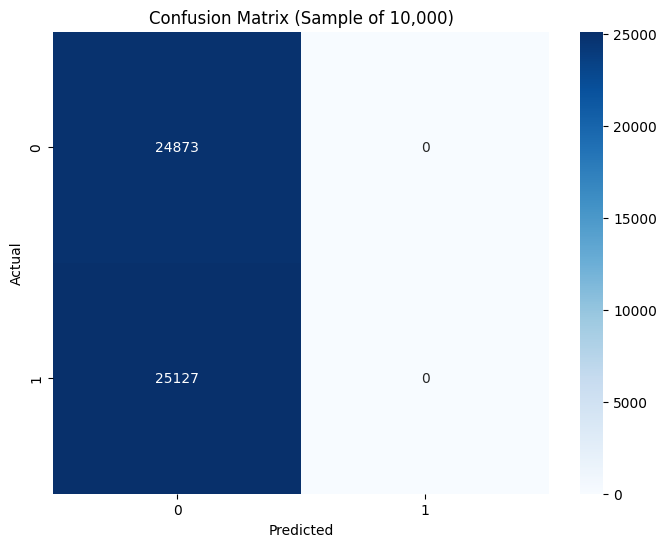

In [104]:
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Subset

# Step 1: Sample 10,000 random indices from eval dataset
eval_dataset = trainer.eval_dataset
sample_size = min(50000, len(eval_dataset))
random_indices = random.sample(range(len(eval_dataset)), sample_size)

# Step 2: Create a subset
sampled_eval_dataset = Subset(eval_dataset, random_indices)

# Step 3: Run prediction on the subset
sampled_output = trainer.predict(sampled_eval_dataset)
preds = np.argmax(sampled_output.predictions, axis=1)
labels = sampled_output.label_ids

# Step 4: Compute confusion matrix
cm = confusion_matrix(labels, preds)
print(classification_report(labels, preds))

# Step 5: Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Sample of 10,000)')
plt.show()


In [111]:
sample_output = trainer.predict(trainer.eval_dataset.select(range(5)))

# Raw logits
logits = sample_output.predictions
print("Raw logits:\n", logits)

probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
print("\nSoftmax probabilities:\n", probs)

preds = np.argmax(probs, axis=1)
print("\nPredicted labels:", preds)

true_labels = sample_output.label_ids
print("True labels:     ", true_labels)

Raw logits:
 [[-0.02984716]
 [ 0.00765086]
 [-0.01901553]
 [ 0.42898566]
 [ 0.41167766]]

Softmax probabilities:
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]

Predicted labels: [0 0 0 0 0]
True labels:      [1. 0. 0. 1. 0.]


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on the eval dataset
preds_output = trainer.predict(sampled_eval_dataset)
logits = preds_output.predictions
labels = preds_output.label_ids

# Apply sigmoid for binary classification



              precision    recall  f1-score   support

           0       0.00      0.00      0.00     24873
           1       0.50      1.00      0.67     25127

    accuracy                           0.50     50000
   macro avg       0.25      0.50      0.33     50000
weighted avg       0.25      0.50      0.34     50000

Confusion Matrix:
 [[    0 24873]
 [    0 25127]]


/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/stygianphantom/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [123]:
probs = 1 / (1 + np.exp(-logits))
preds = (probs > 0.51).astype(int)

# Flatten in case logits are shaped (N, 1)
preds = preds.flatten()
labels = labels.astype(int)

# Recompute metrics
print(classification_report(labels, preds))
print("Confusion Matrix:\n", confusion_matrix(labels, preds))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86     24873
           1       0.83      0.95      0.88     25127

    accuracy                           0.87     50000
   macro avg       0.88      0.87      0.87     50000
weighted avg       0.88      0.87      0.87     50000

Confusion Matrix:
 [[19940  4933]
 [ 1336 23791]]


In [124]:
trainer.save_model("hate_speech_recall_optimized_model")

# Save tokenizer too (important!)
tokenizer.save_pretrained("hate_speech_recall_optimized_model")

('hate_speech_recall_optimized_model/tokenizer_config.json',
 'hate_speech_recall_optimized_model/special_tokens_map.json',
 'hate_speech_recall_optimized_model/vocab.txt',
 'hate_speech_recall_optimized_model/added_tokens.json',
 'hate_speech_recall_optimized_model/tokenizer.json')

In [125]:
from transformers import Trainer

# Step 1: Load model and tokenizer
model_path = "hate_speech_recall_optimized_model"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Step 2: Re-initialize Trainer (must pass same eval_dataset!)
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    eval_dataset=sampled_eval_dataset  # or full eval_dataset
)

/var/folders/sy/j85r4wzj1b76bxxb72ht66cr0000gn/T/ipykernel_28781/2324367296.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [126]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on the eval dataset
preds_output = trainer.predict(sampled_eval_dataset)
logits = preds_output.predictions
labels = preds_output.label_ids

KeyboardInterrupt: 